Drifted Sensor Detection
========================

Detect drifted sensors

Aims:
* Detect drfited sensors
* For outlier detection and real time applications

Methods:
1. Pearson coefficient + Signal strength
2. PCA and modified ZScore

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

sns.set_style('white')
sns.set_context("poster")

## Data Inspection

Read in 4 strain gauges within the same sensor group. The signals were resampled to 30S interval (from 1S), which might lower the quality of the data.

In [2]:
df = pd.read_hdf('drifted_sensors.h5', 'table')
sensors = df.columns
df.head()

,str_166,str_167,str_168,str_169
timestamp,,,,
2016-01-01 00:00:00,NaN,NaN,NaN,NaN
2016-01-01 00:00:30,NaN,NaN,NaN,NaN
2016-01-01 00:01:00,NaN,NaN,NaN,NaN
2016-01-01 00:01:30,NaN,NaN,NaN,NaN
2016-01-01 00:02:00,NaN,NaN,NaN,NaN


In [18]:
import matplotlib.dates as mdates

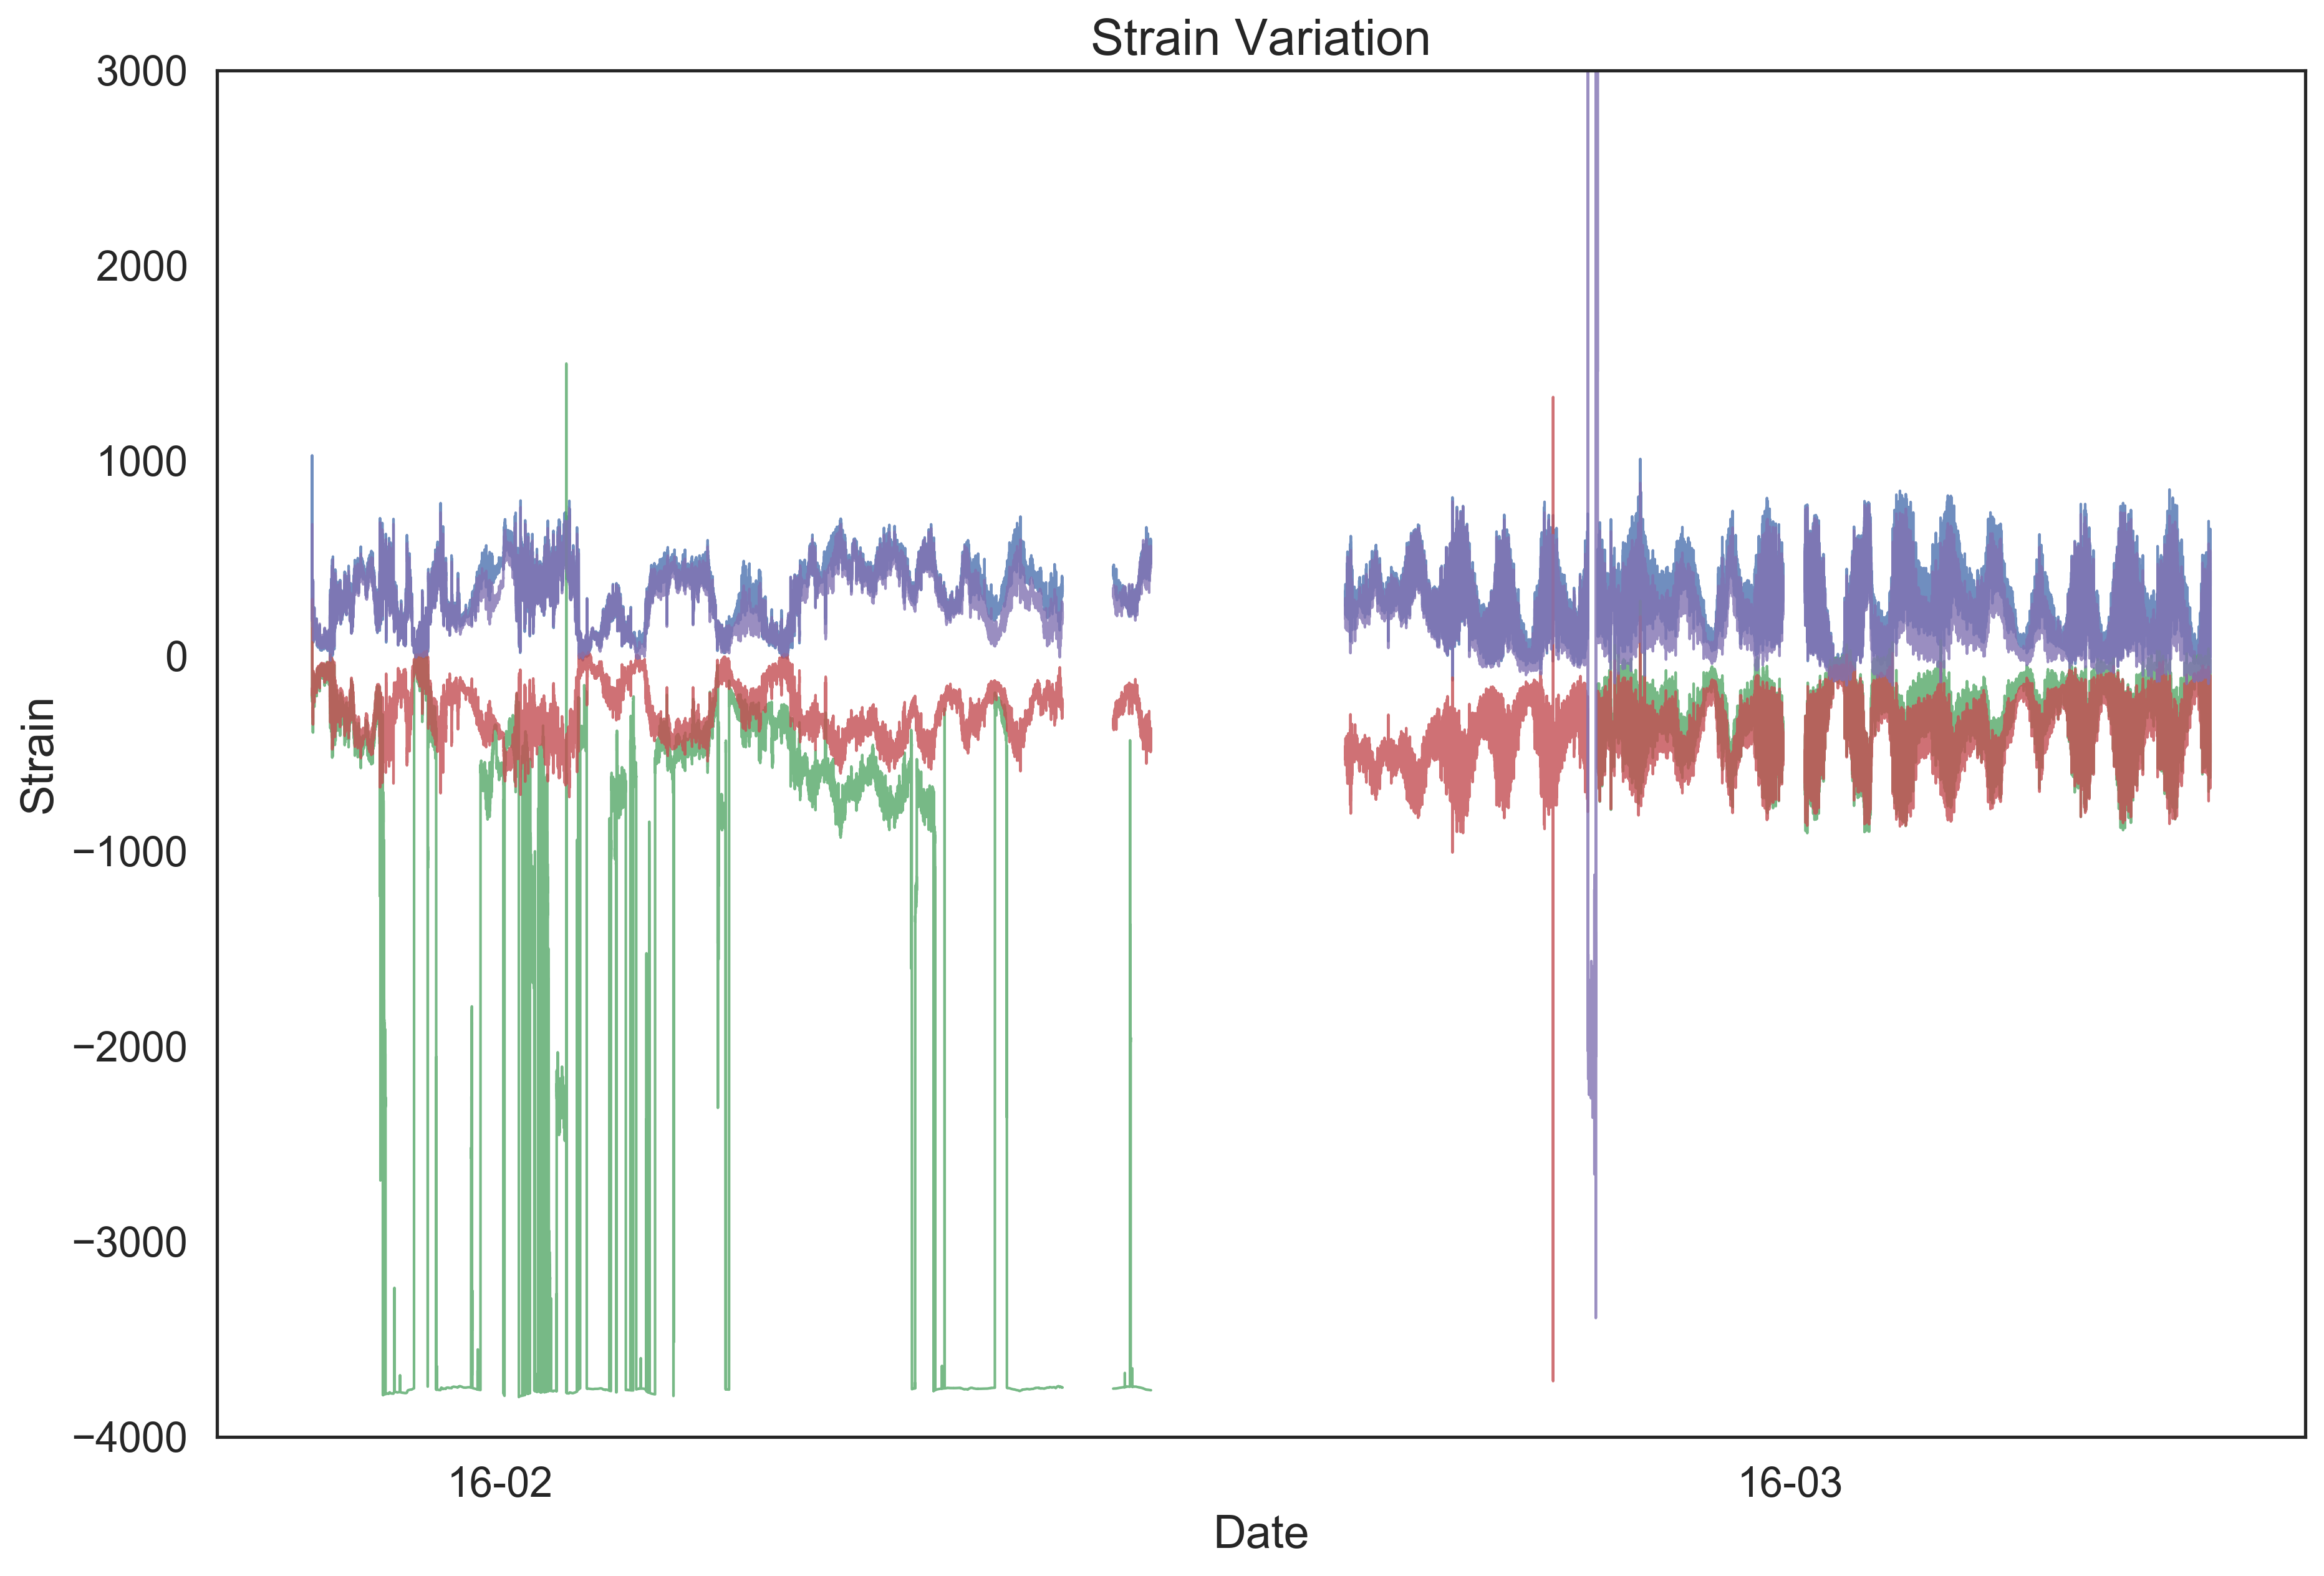

In [29]:
fig, ax = plt.subplots(dpi=300)
plt.plot(df, linewidth=1, alpha=0.8)
plt.title('Strain Variation')
plt.ylabel('Strain')
plt.xlabel('Date')

plt.ylim((-4000, 3000))
ax.xaxis.set_major_locator(mdates.MonthLocator())
Fmt = mdates.DateFormatter("%y-%m")
ax.xaxis.set_major_formatter(Fmt)
plt.tight_layout()

# plt.savefig("out-str-var.png")

Cut down sample size so my computer can handle it

In [4]:
df = df.iloc[0:200000]

## Computing Rolling Pearson Coefficient

In [5]:
# rolling Pearson coefficient
corr = (df.rolling(window=5)
          .corr()
          .swaplevel(0, 1, axis=0)
          .abs())
corr.head()

,,str_166,str_167,str_168,str_169
,timestamp,,,,
str_166,2016-01-01 00:00:00,NaN,NaN,NaN,NaN
str_167,2016-01-01 00:00:00,NaN,NaN,NaN,NaN
str_168,2016-01-01 00:00:00,NaN,NaN,NaN,NaN
str_169,2016-01-01 00:00:00,NaN,NaN,NaN,NaN
str_166,2016-01-01 00:00:30,NaN,NaN,NaN,NaN


We'll need to set a 'anomaly' threshold, under which means there's something different in the data.

In [6]:
threshold_corr = 0.9
drifted_sen = (corr[corr < threshold_corr].dropna(how='all')
               .notnull()
               .sum()
               .sort_values(ascending=False)
               .keys()[0])
print("Drifted Sensor (if any): {}".format(drifted_sen))

Drifted Sensor (if any): str_167


Find the drifted sensor and the timestamp

In [7]:
drifted = ((corr[drifted_sen].drop(drifted_sen, level=0)
           < threshold_corr).reset_index()
                            .drop('level_0', axis=1)
                            .drop_duplicates(subset='timestamp')
                            .set_index('timestamp')
                            .replace(False, np.nan)
                            .replace(True, drifted_sen))
drifted.columns = ['drifted']
drifted.head()

,drifted
timestamp,
2016-01-01 00:00:00,NaN
2016-01-01 00:00:30,NaN
2016-01-01 00:01:00,NaN
2016-01-01 00:01:30,NaN
2016-01-01 00:02:00,NaN


Append original dataframe and the drifted dataframe together

In [8]:
dd = pd.concat([df, drifted], axis=1)
# dd.head()

Creates a function that plot the data and show periods when there's a sensor drift

In [9]:
# plot data and highlight drifted sensor period
dd.drifted = dd.drifted.astype('category').cat.codes + 1 # tranlate boolean to int

def plot_drifted(df, outlier):
    fig, ax = plt.subplots()
    
    for col in df.columns:
        ax.plot(df.index, df[col].values, '.', markersize=2)

    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(df.index, 0, 100, where=outlier > 0, transform=trans, alpha=0.3)
    plt.title('Strain Variation')

Add a new column to find the absoluate value of the 4 combined signals

In [10]:
dd = dd.dropna()
dd['sum'] = dd.drop('drifted', axis=1).sum(axis=1).abs()
dd.head()

,str_166,str_167,str_168,str_169,drifted,sum
timestamp,,,,,,
2016-01-27 18:43:00,556.125099,-199.866809,-173.528500,196.925403,0,379.655193
2016-01-27 18:43:30,204.388365,-210.693520,-183.412019,208.155197,0,18.438023
2016-01-27 18:44:00,211.755245,-219.981983,-191.776832,214.322031,0,14.318461
2016-01-27 18:44:30,207.697539,-214.246921,-186.535087,211.056376,0,17.971908
2016-01-27 18:45:00,187.349090,-193.547896,-167.537169,192.534117,1,18.798142


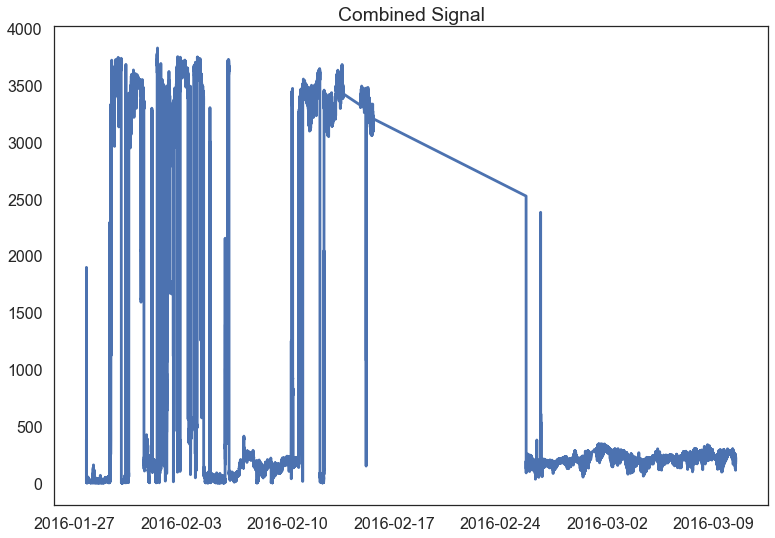

In [11]:
plt.plot(dd['sum'])
plt.title('Combined Signal')

In [14]:
c_orange_d = '#FF5722'
c_orange = '#FF9800'
c_red = '#D32F2F'
c_green_d = '#388E3C'
c_green = '#4CAF50'
c_blue_d = '#303F9F'
c_blue_l = '#2196F3'
c_teal_d = '#00796B'
c_purple = '#9C27B0'
c_purple_d = '#512DA8'
c_yellow_d = '#FFA000'
c_yellow = '#FFC107'
c_grey = '#607D8B'
c_grey_d = '#455A64'

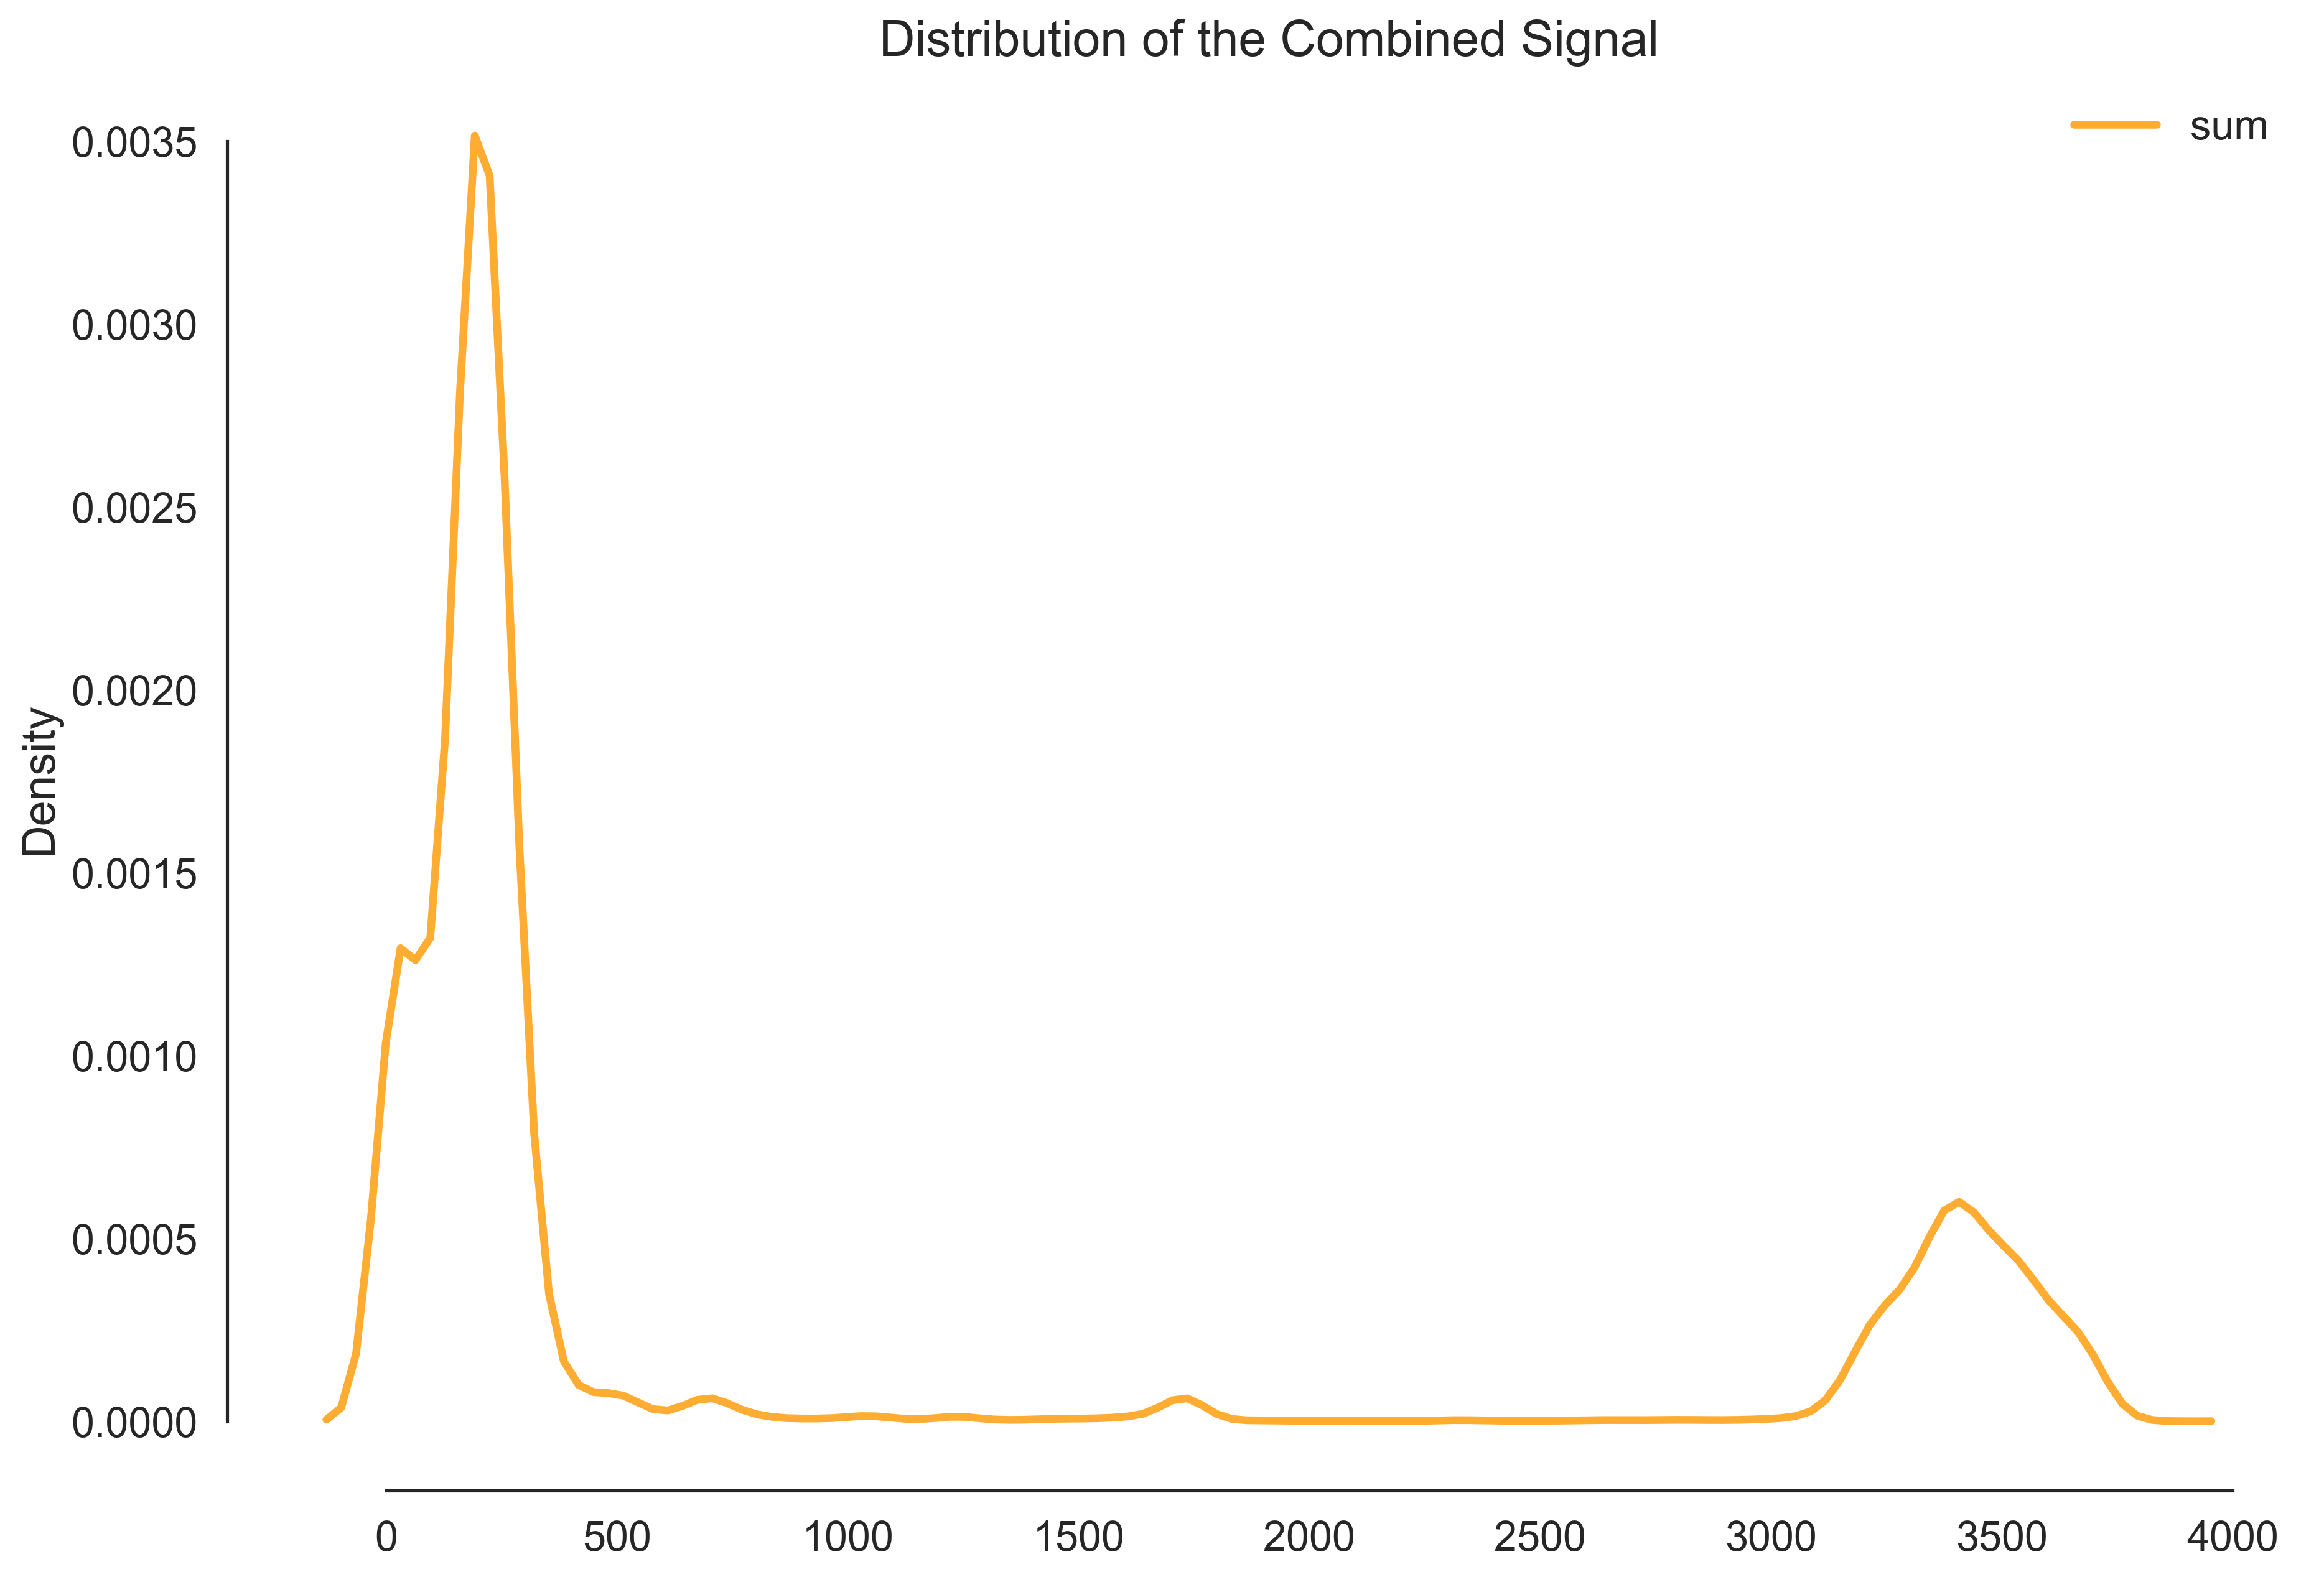

In [31]:
fig, ax = plt.subplots(dpi=300)
sns.kdeplot(dd['sum'], linewidth=3, color=c_orange, alpha=0.8)
plt.title('Distribution of the Combined Signal')
plt.ylabel('Density')
# plt.xlabel('Strain')
plt.tight_layout()
sns.despine(offset=2, trim=True)
plt.savefig('out-str-sum-dist.png')

Setting the threshold: when sum of signals > 500

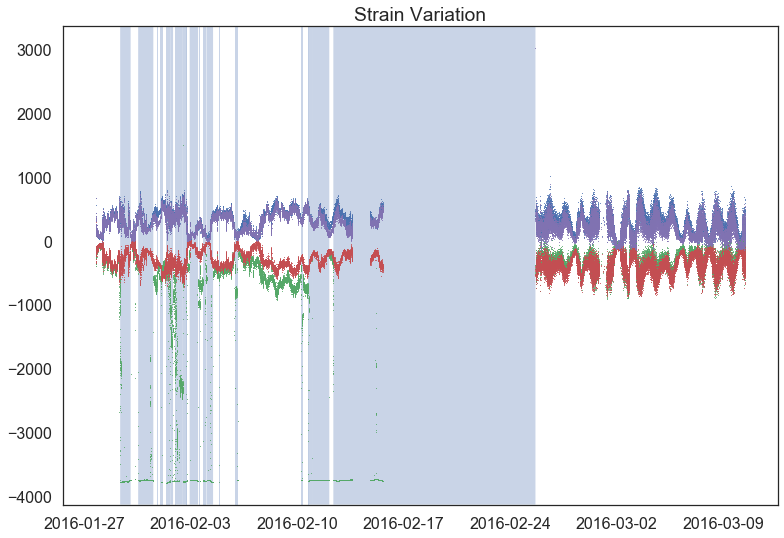

In [33]:
dd['drifted_real'] = (dd['sum'] > 500) | (dd['drifted'] == 1)
plot_drifted(dd[sensors], dd.drifted_real)

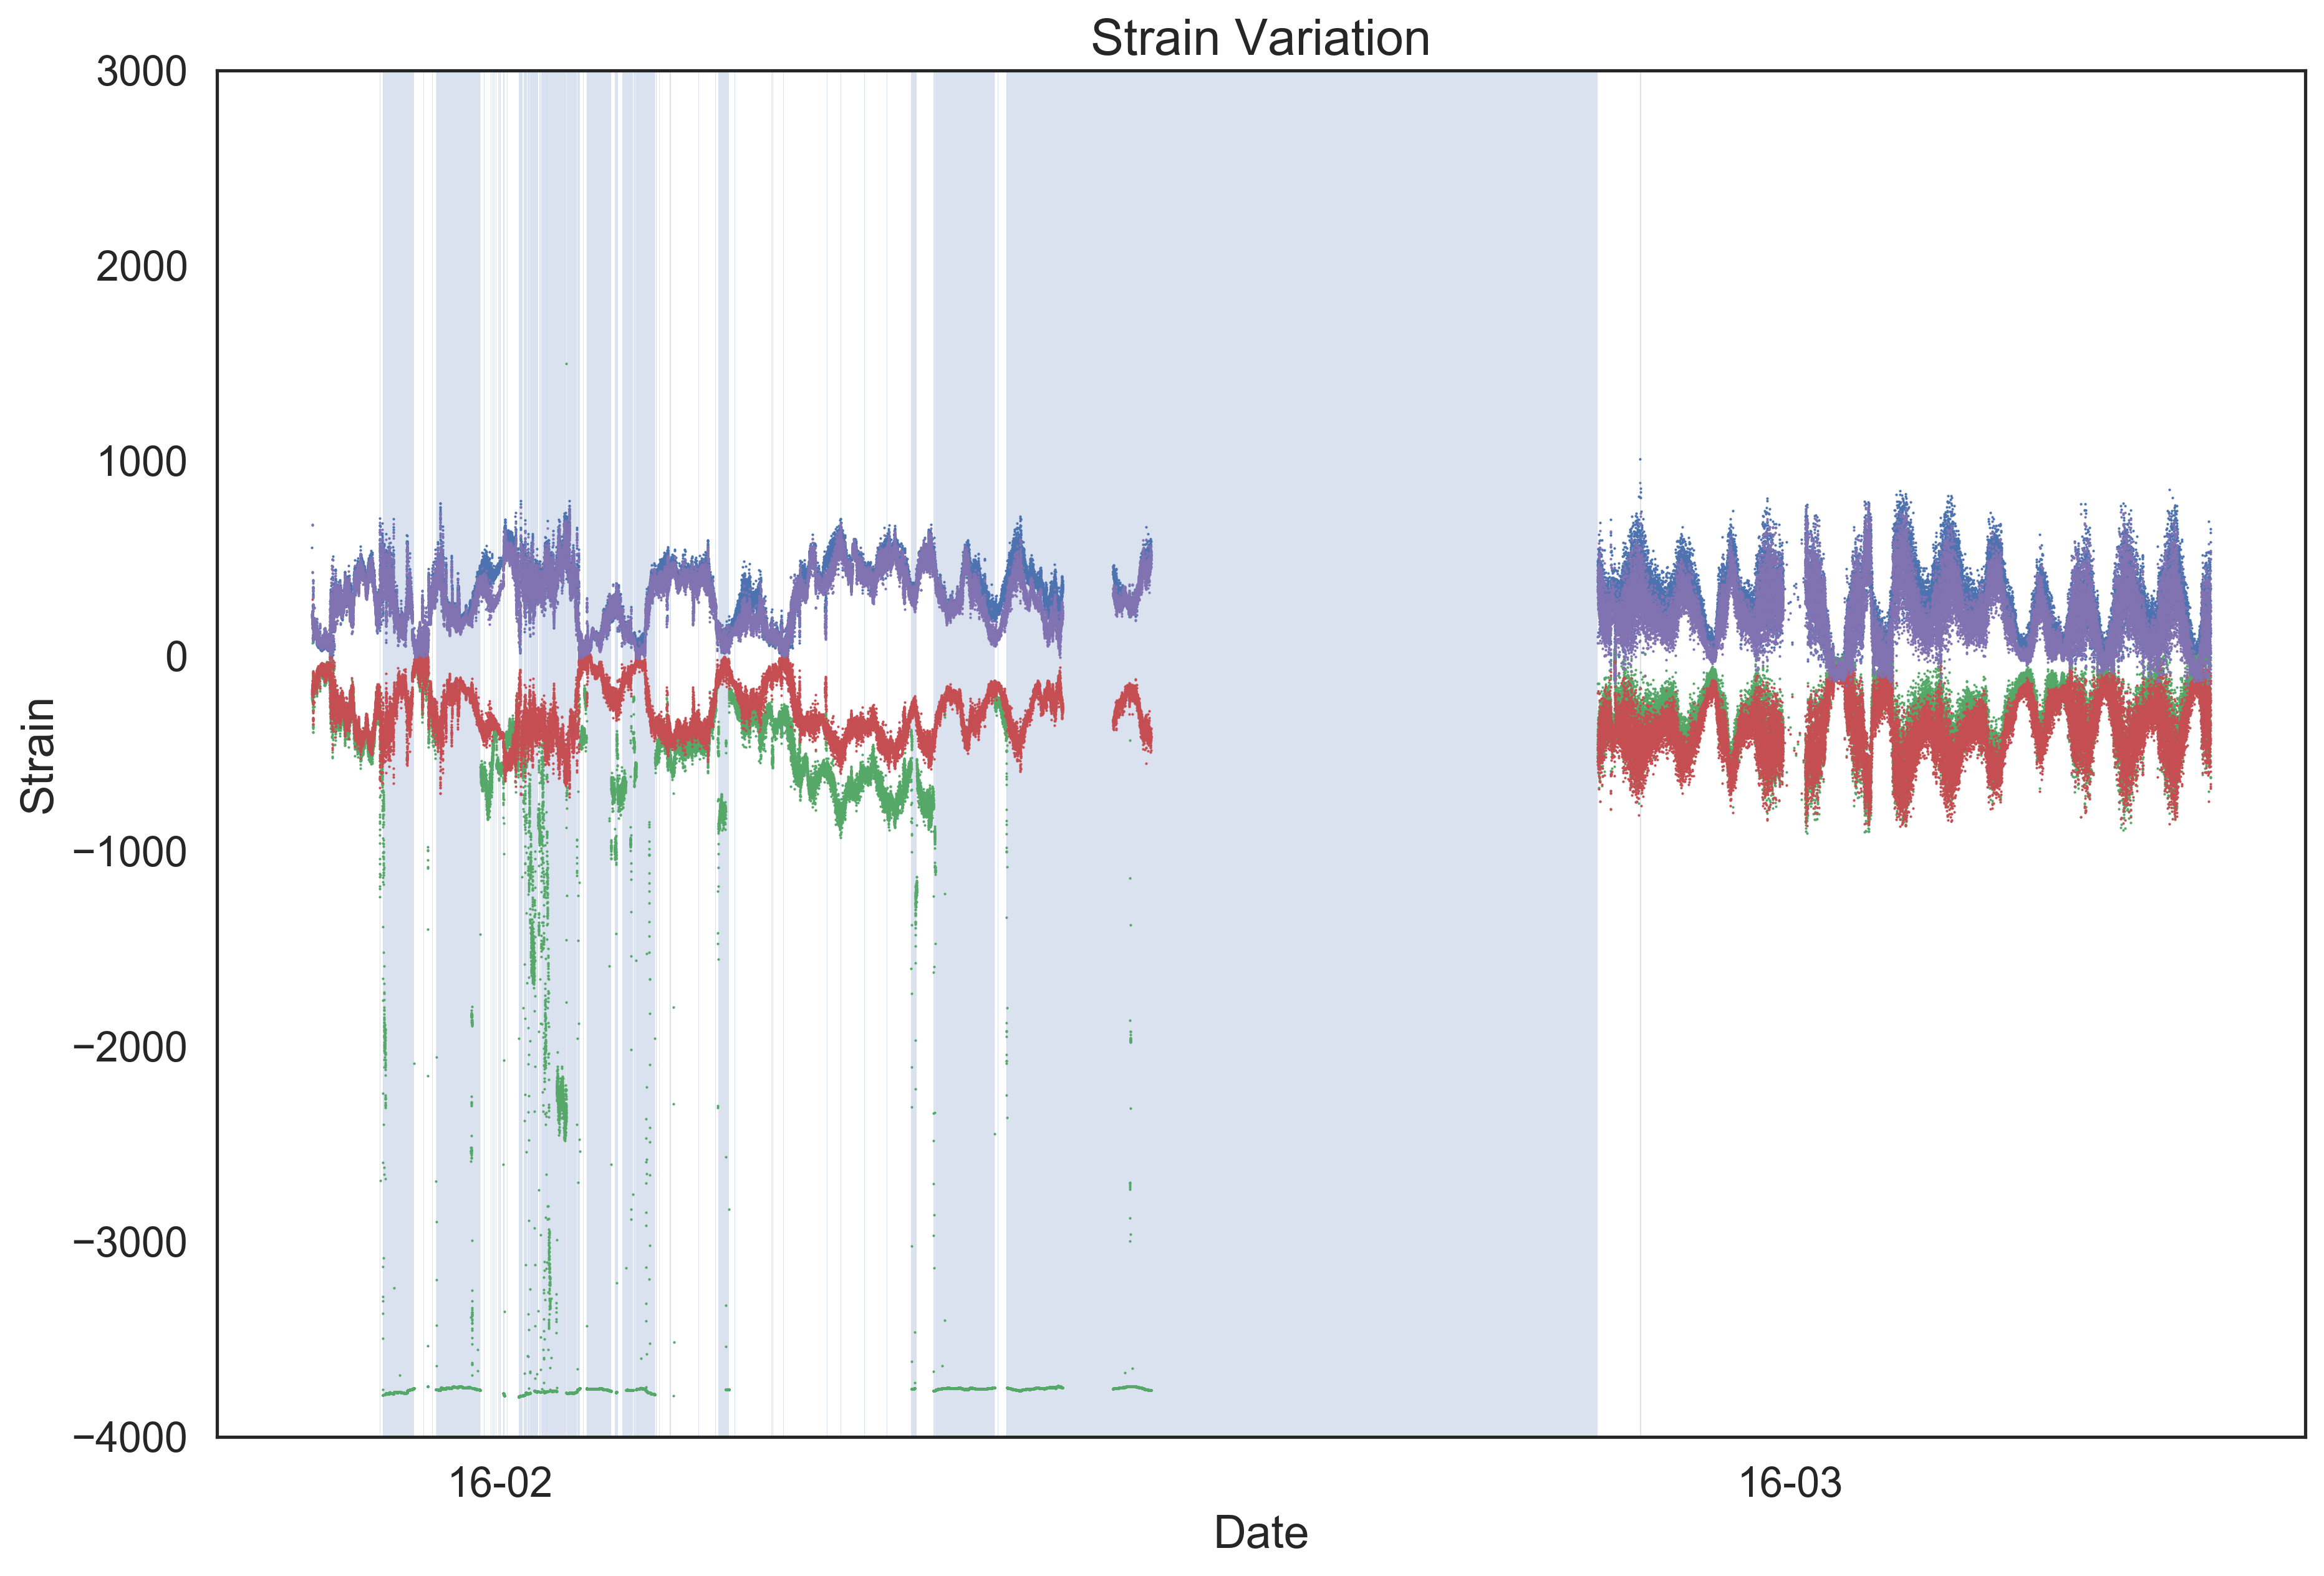

In [52]:
def plot_drifted(df, outlier):
    fig, ax = plt.subplots(dpi=300)
    
    for col in df.columns:
        ax.plot(df.index, df[col].values, '.', markersize=2)

    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(df.index, 0, 100, where=outlier > 0, transform=trans, alpha=0.2)
    plt.title('Strain Variation')
    plt.ylabel('Strain')
    plt.xlabel('Date')
    plt.ylim((-4000, 3000))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    Fmt = mdates.DateFormatter("%y-%m")
    ax.xaxis.set_major_formatter(Fmt)
    plt.tight_layout()
    plt.savefig("out-str-var-det.png")

# plot_drifted(dd.iloc[0:44597][sensors], dd.iloc[0:44597].drifted_real)
plot_drifted(dd[sensors], dd.drifted_real)

# plt.savefig("out-str-var-det.png")

Note: shaded areas indicate the algorithm detects a drifted sensor

ZOOM IN: Inspect data from 2016-02-05 12:00:00 to 2016-02-08 00:00:00

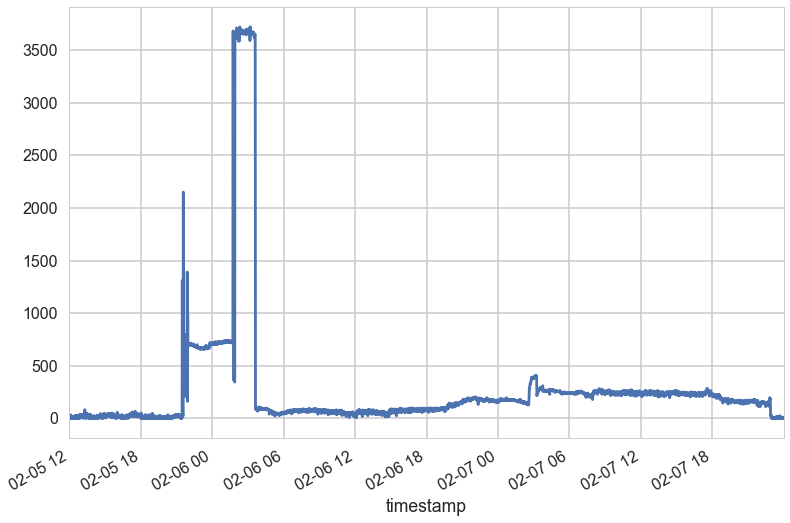

In [14]:
dd.loc['2016-02-05 12:00:00':'2016-02-07']['sum'].plot()

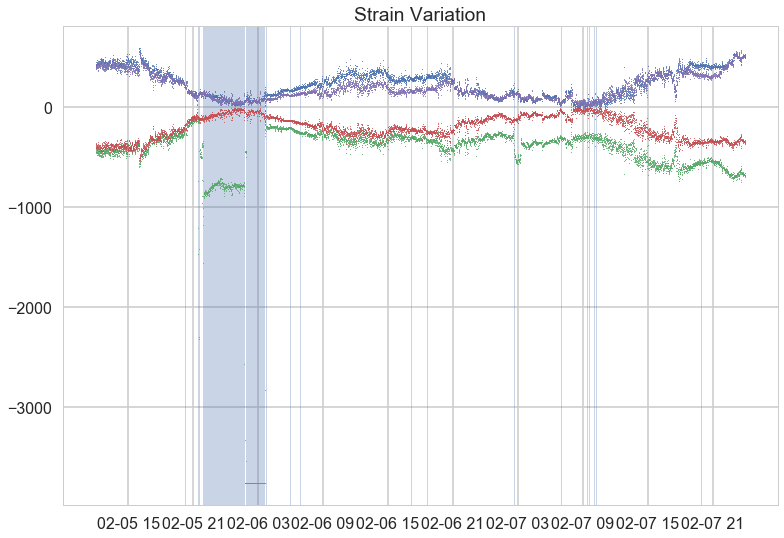

In [15]:
plot_drifted(dd.loc['2016-02-05 12:00:00':'2016-02-07'][sensors], dd.drifted_real.loc['2016-02-05 12:00:00':'2016-02-07'])

Current Limitation:
* need to set 2 parameter (thresholds) manually
* assume only one sensor drifted
* code not optimized (speed and memory)

## Real Time Drifted Sensor Detection

Using a even smaller sample size - so my computer can handle it

In [3]:
d = df.loc['2016-01-29 07:00:00':'2016-01-29 07:30:00']
d.head()

,str_166,str_167,str_168,str_169
timestamp,,,,
2016-01-29 07:00:00,206.015150,-226.294722,-207.256343,207.861556
2016-01-29 07:00:30,184.785601,-206.577744,-189.325524,187.855858
2016-01-29 07:01:00,230.904143,-245.065466,-223.669096,231.947352
2016-01-29 07:01:30,231.539672,-250.546401,-227.266072,237.854677
2016-01-29 07:02:00,233.663617,-254.821498,-230.953806,243.363391


In [27]:
# threshold for modified zscore -- 3.5 is the standard
threshold_zscore = 3.5
outlier_times = []

def modified_zscore(Xs):
    # returns the position of outlier and corresponding zscore
    median = np.median(Xs)
    MAD = np.median([np.abs(X - median) for X in Xs])
    mzscores = [0.6745 * (X - median) / MAD for X in Xs]
    pos_outlier = np.where(np.abs(mzscores)
                           > threshold_zscore)[0]     # it returns narray inside tuple
    # if no outlier detected
    if pos_outlier.size == 0:
        return False, False
    return pos_outlier, mzscores[pos_outlier[0]]


def pca_fit_explained(X):
    # return the explained ratio
    pca = PCA(n_components=1).fit(X)
    return pca.explained_variance_ratio_[0]


def pca_sensors(df):
    """Returns whether there's a outlier or not"""
    # do PCA, each iteration drop 1 sensor
    columns = df.columns
    explained_ratio = []
    for col in columns:
        d = df.drop(col, axis=1)
        explained_ratio.append(pca_fit_explained(d))

    pos_outlier, z_outlier = modified_zscore(explained_ratio)
    
    if pos_outlier == False:
        print("{}\tNo Outlier Detected".format(df.index[0]))
        return 0
    else:
        outlier = columns[pos_outlier][0]
#         print("Outlier {} with zscore {:.2f} @ {}".format(outlier, z_outlier, df.index[0]))
        print("{}\t{} (z-score = {:.2f})".format(df.index[0], outlier, z_outlier))
        return 1
    

def pca_outlier(df):
    res = pca_sensors(df)
    return df.index[0], res


1. Iterate through different combinations (each time drop a different sensor)
2. Apply PCA and compute explained ratio
3. Compare the explained ratio of sensors using Modified Zscore method
4. Identify the sensor with explained ratio significantly different to others (using standard modified zscore formula)
5. Return if there's a drifted sensor

Set up a window size and 'simulate' real-time scenarios

In [28]:
window = 5 # that's 2.5 mins
index = []
outliers = []

# slice dataframe
for i in range(0, len(d), 1):
    slc_df = d.iloc[i:i+window].dropna()
    i, outlier = pca_outlier(slc_df)
    index.append(i)
    outliers.append(outlier)

2016-01-29 07:00:00	No Outlier Detected
2016-01-29 07:00:30	No Outlier Detected
2016-01-29 07:01:00	No Outlier Detected
2016-01-29 07:01:30	No Outlier Detected
2016-01-29 07:02:00	No Outlier Detected
2016-01-29 07:02:30	No Outlier Detected
2016-01-29 07:03:00	No Outlier Detected
2016-01-29 07:03:30	No Outlier Detected
2016-01-29 07:04:00	No Outlier Detected
2016-01-29 07:04:30	No Outlier Detected
2016-01-29 07:05:00	No Outlier Detected
2016-01-29 07:05:30	No Outlier Detected
2016-01-29 07:06:00	No Outlier Detected
2016-01-29 07:06:30	No Outlier Detected
2016-01-29 07:07:00	No Outlier Detected
2016-01-29 07:07:30	No Outlier Detected
2016-01-29 07:08:00	No Outlier Detected
2016-01-29 07:08:30	No Outlier Detected
2016-01-29 07:09:00	No Outlier Detected
2016-01-29 07:09:30	No Outlier Detected
2016-01-29 07:10:00	No Outlier Detected
2016-01-29 07:10:30	No Outlier Detected
2016-01-29 07:11:00	No Outlier Detected
2016-01-29 07:11:30	No Outlier Detected
2016-01-29 07:12:00	No Outlier Detected


C:\Users\brian1123\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\brian1123\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in greater
C:\Users\brian1123\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:398: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\brian1123\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [6]:
# prepare for data visulization
anomalies = pd.DataFrame(outliers, index=index, columns=['outlier'])
anomalies.head()

,outlier
2016-01-29 07:00:00,0
2016-01-29 07:00:30,0
2016-01-29 07:01:00,0
2016-01-29 07:01:30,0
2016-01-29 07:02:00,0


In [8]:
import matplotlib.dates as mdates

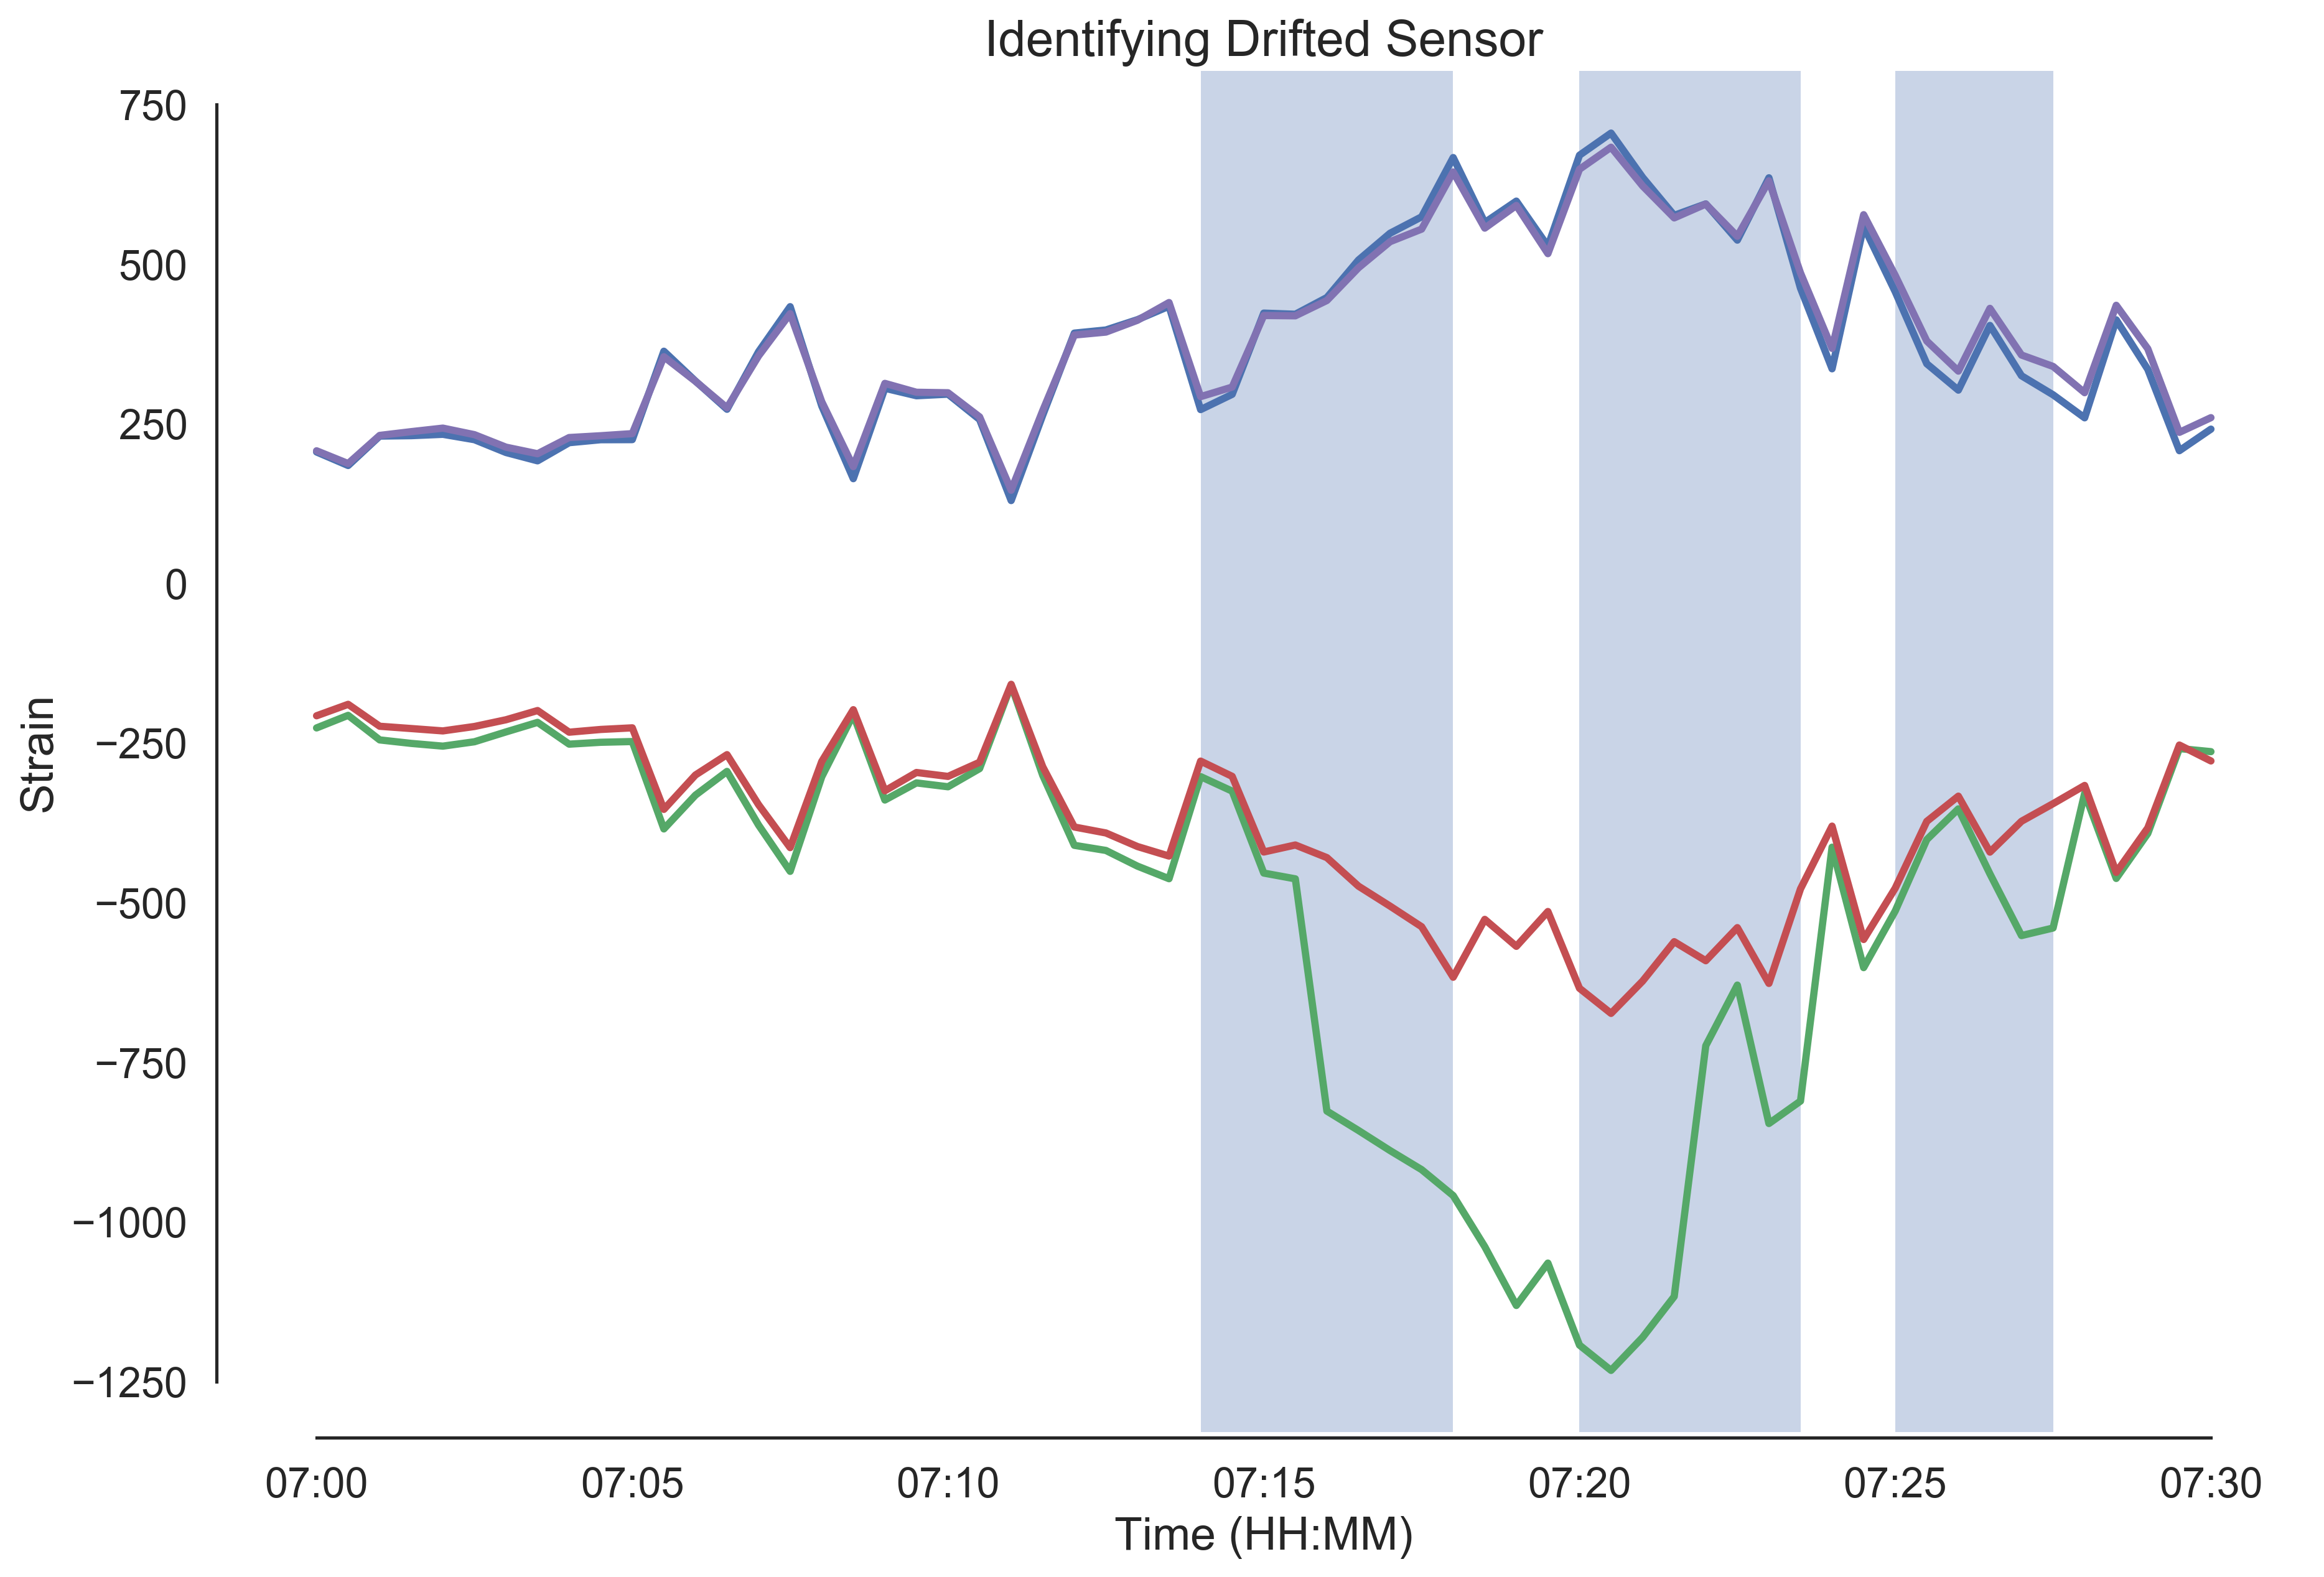

In [29]:
def plot_drifted(df, outlier):
    fig, ax = plt.subplots(dpi=300)
    
    for col in df.columns:
        ax.plot(df.index, df[col].values)#, '.', markersize=2)

    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(df.index, 0, 100, where=outlier > 0, transform=trans, alpha=0.3)
    plt.title('Identifying Drifted Sensor')
    plt.ylabel('Strain')
    plt.xlabel('Time (HH:MM)')
    plt.tight_layout()
    sns.despine(offset=2, trim=True)
    xfmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    plt.savefig('PCC-drifted-sensor.png')
    
    
plot_drifted(d, anomalies.outlier)

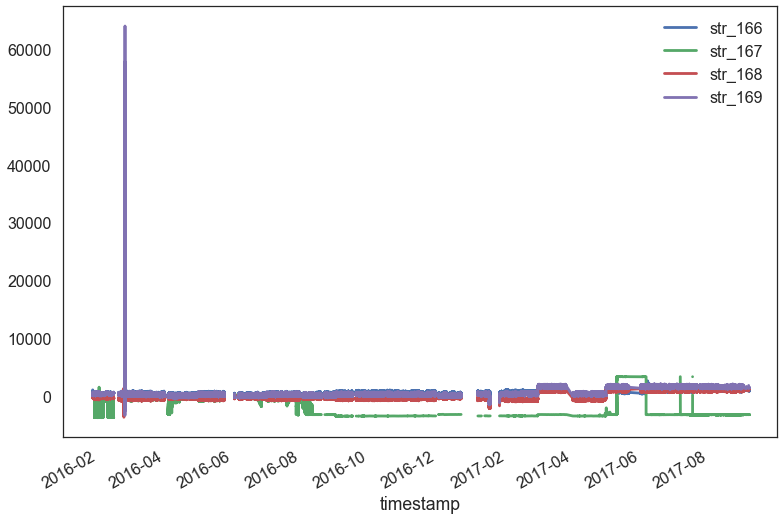

In [14]:
df.plot()

Note: the algorithm cannot detect the drifted sensor at 07:18 since the gradient of the drifted sensor is similar to other sensors, the "sum of signals and set a threshold" method (see the first method) can be used.

These methods are only a proof of concept, more testing and parameter tuning is required to increase the accuracy of the detection. 

Thanks for reading, feedback is greatly appreciated!